In [1]:
from google.colab import files
uploaded = files.upload()

Saving churn_prediction.csv to churn_prediction.csv


In [34]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.ticker as mtick
from sklearn.metrics import plot_confusion_matrix

In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['churn_prediction.csv']))
df = df.drop(columns = ['customerID'])
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#Feature Engineering


In [4]:
#Converting total charges to float
df["TotalCharges"] = pd.to_numeric(df.TotalCharges, errors='coerce')
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [5]:
df = df.dropna()
df.isnull().sum() #Count Rows containing NaN
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
for col in df.columns:
    print(col, ': ', len(df[col].unique()), ' labels')

gender :  2  labels
SeniorCitizen :  2  labels
Partner :  2  labels
Dependents :  2  labels
tenure :  72  labels
PhoneService :  2  labels
MultipleLines :  3  labels
InternetService :  3  labels
OnlineSecurity :  3  labels
OnlineBackup :  3  labels
DeviceProtection :  3  labels
TechSupport :  3  labels
StreamingTV :  3  labels
StreamingMovies :  3  labels
Contract :  3  labels
PaperlessBilling :  2  labels
PaymentMethod :  4  labels
MonthlyCharges :  1584  labels
TotalCharges :  6530  labels
Churn :  2  labels


In [7]:
df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [8]:
#One hot Encoding
df2 = pd.get_dummies(df)
df2.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


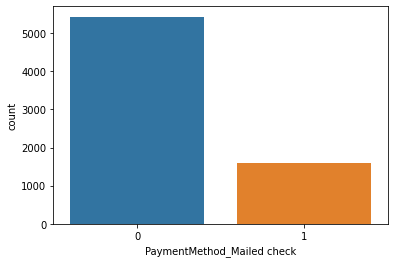

In [9]:
sns.countplot(df2.iloc[:,-1])

It is clear from the above histogram that the classes are highly imbalanced in the data set. A sampling technique must be used in order to balance the distribution of the classes

SMOTE is a sampling technique used to deal with imbalanced datasets. It creates new samples of the 'minority' class by taking the nearest neighbors of the samples present. 

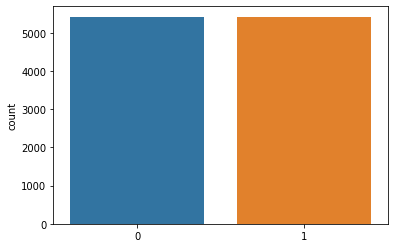

In [10]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(df2.iloc[:,0:-2], df2.iloc[:,-1])
#X_sm, y_sm = smote.fit_sample(X_sm, y_sm)
sns.countplot(y_sm)

#Exploratory Data Analysis


In [11]:
import seaborn as sns
import plotly.figure_factory as ff

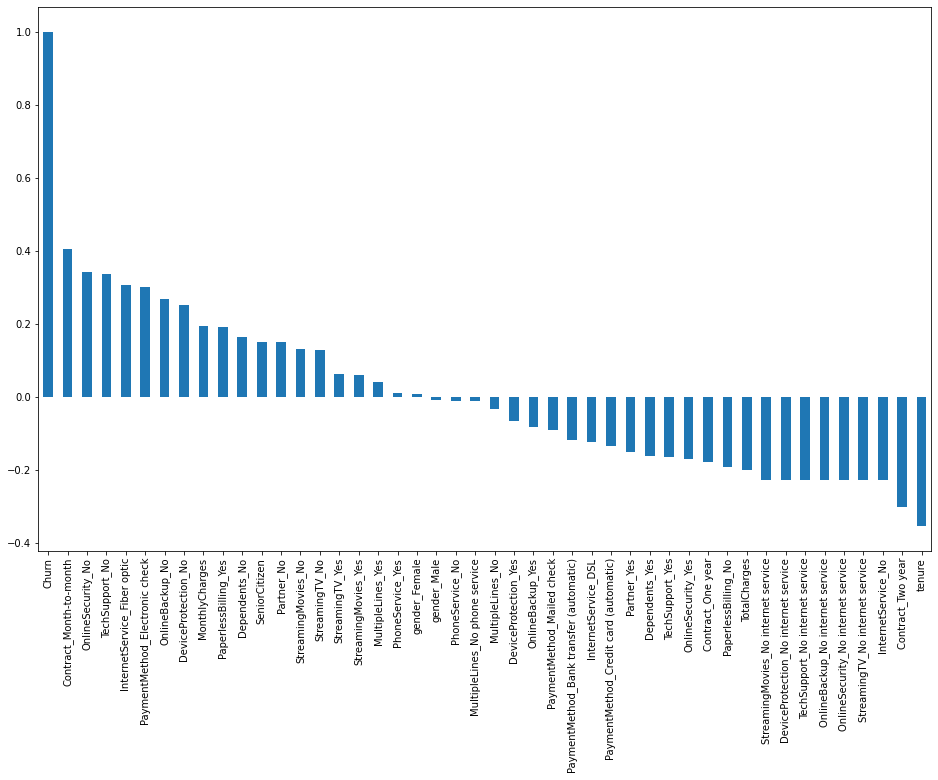

In [12]:
plt.figure(figsize=(16,10))
df2.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

Customers having monthly contracts tend to churn more (high positive correlation) while customers having two-year contract tend to churn less (high negative correlation). Tenure also is a good indicator of customers staying with the telecom provider (Higher the tenure lower the probablity of churn)

In [13]:
def plots(feature):
    plt.figure(figsize=(9, 4))
    plt.title("Plot for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Churn'] == 0][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Churn'] == 1][feature].dropna(), color= 'orange', label= 'Churn: Yes')

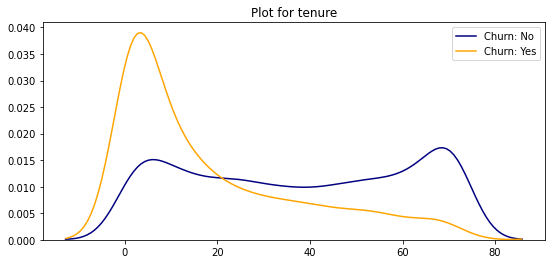

In [14]:
plots('tenure')

The above inference can be supported here. As the tenure increase customers tend to churn less. 

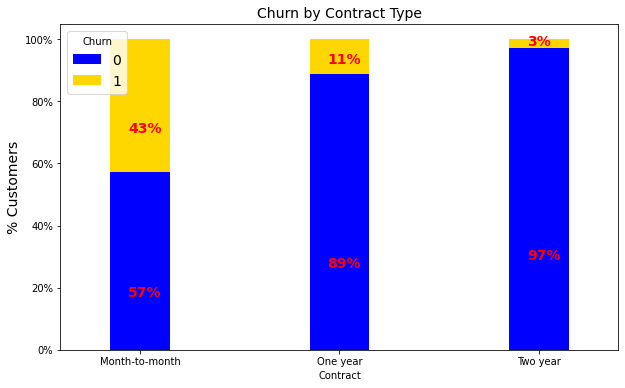

In [20]:
colors = ['blue','gold']
contract_churn = df.groupby(['Contract','Churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Contract Type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.30*width, p.get_y()+.3*height),
                color = 'red',
               weight = 'bold',
               size = 14)

Customers with 2 year contracts tend to churn less compared to customers with monthly contracts. This observations is also consistent with the initail correlation analysis.

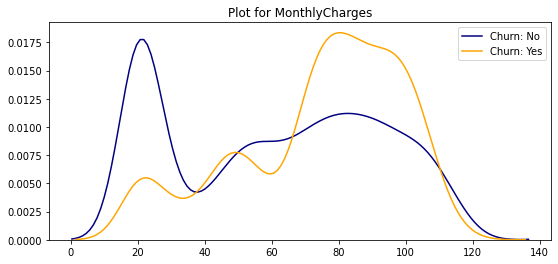

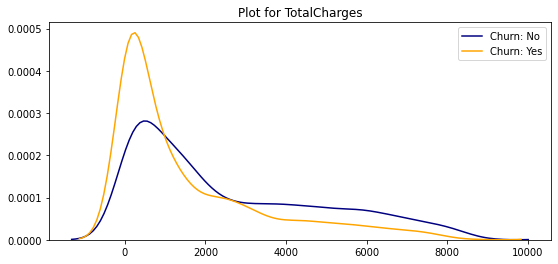

In [15]:
plots('MonthlyCharges')
plots('TotalCharges')

                MonthlyCharges  TotalCharges    tenure     Churn
MonthlyCharges        1.000000      0.651065  0.246862  0.192858
TotalCharges          0.651065      1.000000  0.825880 -0.199484
tenure                0.246862      0.825880  1.000000 -0.354049
Churn                 0.192858     -0.199484 -0.354049  1.000000


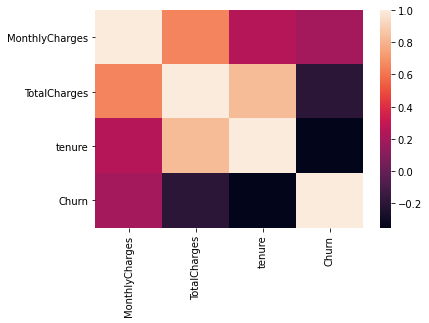

In [17]:
corr_charges = df[["Contract","MonthlyCharges","TotalCharges","tenure","Churn"]].corr()
print(corr_charges)
sns.heatmap(corr_charges)

Correlation of total Charges with Monthly Charges and tenure is very high - 65% and 82.5% respectively. Thus, Total charges is redundant variable.

In [21]:
df = df.drop(columns = ["TotalCharges"])

#Feature Selection

In [22]:
X = pd.DataFrame(X_sm)
y = pd.DataFrame(y_sm)
X = X.round()
y = y.round()
dummy = pd.concat([X,y], axis = 1)
dummy = dummy.sample(frac = 1)
X = dummy.iloc[:,0:-2]
y = pd.DataFrame(dummy.iloc[:,-1])

In [23]:
#80/20 Split
X_train = X.iloc[0:8000,:]
y_train = y.iloc[0:8000,:]

X_test = X.iloc[8000:-1,:]
y_test = y.iloc[8000:-1,:]
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
9987,0.0,1.0,19.0,19.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
607,0.0,72.0,115.0,8306.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
5971,0.0,17.0,80.0,1387.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
10580,0.0,65.0,45.0,2934.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5106,1.0,50.0,83.0,4114.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [24]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest, chi2
bestfeatures = SelectKBest(score_func=chi2, k=10)

fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)

dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features
featureScores.nlargest(10, 'Score')

    Specs         Score
3       3  2.678080e+06
2       2  2.588803e+04
1       1  1.236041e+04
42     42  1.134395e+03
17     17  7.961246e+02
18     18  6.770514e+02
20     20  6.770514e+02
23     23  6.770514e+02
26     26  6.770514e+02
29     29  6.770514e+02


,Specs,Score
3,3,2.678080e+06
2,2,2.588803e+04
1,1,1.236041e+04
42,42,1.134395e+03
17,17,7.961246e+02
18,18,6.770514e+02
20,20,6.770514e+02
23,23,6.770514e+02
26,26,6.770514e+02
29,29,6.770514e+02


The 10 best features are printed above using the KBestFeatures (Chi squared method). It can be seen that it is in line with the EDA performed above.

#Model Creation

##Decision Tree

Accuracy: 0.7740805604203153
[[1042  349]
 [ 296 1168]]


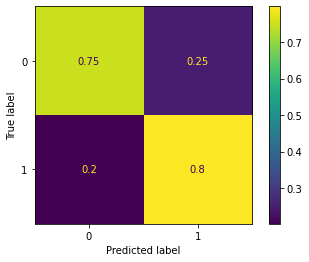

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

#Decision Tree
tree = DecisionTreeClassifier(criterion = "gini",splitter = "best", max_depth=6)
tree = tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(tree, X_test, y_test, normalize='true')

##Random Forest

Accuracy:  0.7810858143607706
Confusion Matrix
[[1042  349]
 [ 296 1168]]


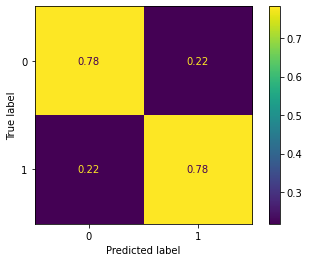

In [60]:
#Random Forest
clf = RandomForestClassifier(max_depth=6, random_state=0)
clf.fit(X_train, y_train)
rf_predict = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, rf_predict))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(clf, X_test, y_test, normalize='true')

##Logistic Regression

Accuracy:  0.7842381786339755
Confusion Matrix
[[1046  345]
 [ 271 1193]]


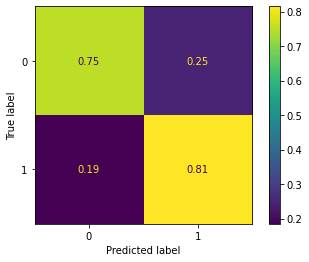

In [61]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(solver = 'newton-cg')
logmodel.fit(X_train , y_train)
LR_predictions = logmodel.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, LR_predictions))
print("Confusion Matrix")
print(confusion_matrix(y_test, LR_predictions))
plot_confusion_matrix(logmodel, X_test, y_test, normalize='true')

##SVM

Accuracy:  0.7947460595446585
Confusion Matrix
[[1134  257]
 [ 329 1135]]


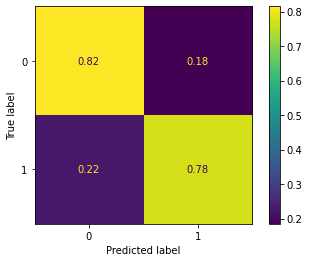

In [62]:
#SVM
from sklearn.svm import SVC
svc = SVC(gamma = 'auto')
svc.fit(X_train, y_train)
svc_predict = svc.predict(X_test)
print("Accuracy: ",accuracy_score(y_test, svc_predict))
print("Confusion Matrix")
print(confusion_matrix(y_test, svc_predict))
plot_confusion_matrix(svc, X_test, y_test, normalize='true')

##Cross Validation

In [63]:
from sklearn.model_selection import cross_validate
cv = cross_validate(svc, X, y, cv=3)['test_score']
print("CV accuracy Scores(SVM):", cv)

CV accuracy Scores(SVM): [0.78695772 0.79248411 0.7896628 ]


An average of 78.9% accuracy is obtained from a 3 fold cross validation. 

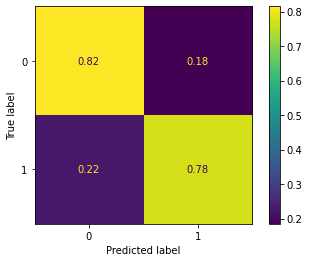

In [64]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(svc, X_test, y_test, normalize='true')